### Functions and script to interface with recorded Harp Binaries

**Inputs:**
- Binary files in session folder saved in 'Behavior.harp', and 'SoundCard.harp' subdirectories.<br>
- Experimental data .csv file in 'Experimental-data' subdirectory containing trial-level behavioural data output directory from Bonsai workflow.

**Key outputs**
- trials_df data frame containing a summary of behavioural events in each trial including harp timestamps for dot onset and offset, nose pokes, and audio onset and offset times within each trial. Note that this data set contains redundancy to double check consistency of trial information between this script and the Bonsai output. 

**Overview** 
1. Create a general reader for the harp behavior board binaries and another specifically for register 32 of the sound card.
2. Align key behavioural events to trials in a pandas data frame in which each row represents one trial. 
3. Append harp data frame to behavioural summary data frame containing trial-level information.


In [1]:
# Import main libraries and define data folder
import numpy as np
import harp
import pandas as pd
from harp.model import Model, Register, Access
import os
import matplotlib.pyplot as plt

import harp_utils as hu

#==============================================================================
animal_ID = 'FNT099'
session_ID = '2024-05-13T11-03-59'

# animal_ID = 'FNT107'
# session_ID = '2024-08-11T14-01-24'

# path behavioural data on ceph repo
input_dir = r"W:\projects\FlexiVexi\behavioural_data" 
output_dir = (r"C:\Users\megan\Documents\sjlab\flexible-navigation-task" +
              r"\Data Analysis\intermediate_variables")

#==============================================================================

# Create reader for behavior.
bin_b_path = os.path.join(input_dir, animal_ID, session_ID, "Behavior.harp")
behavior_reader = harp.create_reader(bin_b_path)

# Specify mapping from sound index to reward port
soundIdx0 = 14
soundIdx1 = 10
soundOffIdx = 18

**Get trial start times from dot onset times**

<Figure size 1200x600 with 0 Axes>

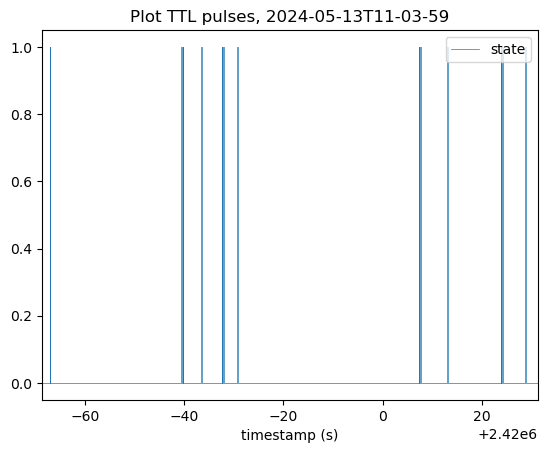

In [2]:
#%matplotlib inline

# Get data frame with state of TTL pulse
ttl_state_df = hu.get_ttl_state_df(behavior_reader)

# Plot ttl trace
plt.figure(figsize=(12, 6))  # Set the figure size (width, height) in inches
ttl_pulse = hu.get_square_wave(ttl_state_df)
ttl_pulse.plot(x='timestamp', y='state', linewidth=0.5)
plt.xlabel('timestamp (s)')
plt.legend(loc='upper right')
plt.title("Plot TTL pulses, " + session_ID)
t0 = ttl_pulse['timestamp'].iloc[0]
plt.xlim(t0, t0 + 100)
plt.show()

**Align dot times with experimental-data-csv**

In [4]:
# Import behavioral data as data frame
session_path = os.path.join(input_dir, animal_ID, session_ID)
filepath = os.path.join(session_path, 'Experimental-data', session_ID + '_experimental-data.csv')
trials_df = pd.read_csv(filepath)

# Get dot onset and offset times given by TTL pulses

## First dot onset time from software clock (used as a common sense check for inconsistencies with number of TTL pulses on start up)
t0 = trials_df['DotOnsetTime'].iloc[0]

## Get dot times from TTL pulses
[dot_times_ttl, ttl_state_0] = hu.get_dot_times_from_ttl(behavior_reader, t0, return_first_dot_onset_TTL_idx=True)
print('TTL state upon start-up: ', ttl_state_0)

# Append dot onset and offset times given by TTL pulses to trials_df
trials_df = pd.concat([trials_df, dot_times_ttl],axis=1)
# rename 'DotOnsetTime' and 'DotOffsetTime' columns to 'DotOnsetTime_harp' and 'DotOffsetTime_harp'
trials_df.rename(columns = {
        'DotOnsetTime_ttl':'DotOnsetTime_harp', 
        'DotOffsetTime_ttl':'DotOffsetTime_harp'
        }, 
    inplace = True)

# Common sense check that the logic of aligning the TTL pulses is working as expected.
# Check dot onset and times from software clock TTL pulses are consistent, given by:
# - DotOnsetTime = dot onset time from software clock
# - DotOnsetTime_ttl = dot onset time from TTL pulses
# - DotOffsetTime = dot offset time from software clock
# - DotOffsetTime_ttl = dot offset time from TTL pulses

trials_df[['TrialStart', 'DotOnsetTime', 'DotOffsetTime', 'DotOnsetTime_harp', 'DotOffsetTime_harp']]


AttributeError: 'numpy.float64' object has no attribute 'iloc'

**Get all poke events**

In [4]:
# Read the behavior harp stream, Digital Input states for the nosepoke timestamps and IDs. Drop DI3 <-- What's DI3??
all_pokes = behavior_reader.DigitalInputState.read()

all_pokes.drop(columns=['DI3','DIPort2'],inplace = True) # remove all nose pokes to dummy port
#all_pokes.reset_index(inplace=True)

# Show resulting data frame
all_pokes.head()

,DIPort0,DIPort1
Time,,
2.419931e+06,False,False
2.419953e+06,True,False
2.419954e+06,False,False
2.419954e+06,True,False
2.419954e+06,False,False


**Get all audio events**

In [5]:
# Load the sound card binary data (register 32) and show resulting dataframe
bin_sound_path = os.path.join(input_dir, animal_ID, session_ID, "SoundCard.harp","SoundCard_32.bin")

# the explicitly defined model will be deprecated or redundant in future
model = Model(device='Soundcard', whoAmI=1280,firmwareVersion='2.2',hardwareTargets='1.1',registers={'PlaySoundOrFrequency': Register(address=32, type="U16", access=Access.Event)})
sound_reader = harp.create_reader(model, keep_type=True)

# Read the harp sound card stream, for the timestamps and audio ID
all_sounds = hu.get_all_sounds(sound_reader, bin_sound_path)

# Show dataframe (maybe)
all_sounds.head(10)

all_sounds_test = all_sounds[all_sounds['PlaySoundOrFrequency'] != soundOffIdx]
all_sounds_test


,Time,PlaySoundOrFrequency,MessageType
3,2.419953e+06,14,EVENT
7,2.419963e+06,10,EVENT
11,2.419983e+06,14,EVENT
15,2.419994e+06,14,EVENT
19,2.419995e+06,14,EVENT
...,...,...,...
2139,2.423117e+06,14,EVENT
2143,2.423121e+06,14,EVENT
2147,2.423129e+06,10,EVENT
2151,2.423136e+06,10,EVENT


**Get trial start times in harp clock**

In [6]:
def get_trial_start_times(stage, **kwargs):

    # NOTE: add optional argument t0 (or even all trial start times) to check for consistency 
    # between software clock and harp clock

    if stage == 4:
        dot_onset_times = kwargs.get('dot_onset_times')
        if dot_onset_times is None:
            raise ValueError("Stage 4 requires 'dot_onset_times' argument.")
        # Process dot onset and offset times
        trial_start_times = dot_onset_times
        return trial_start_times

    elif stage == 5:
        bin_sound_path = kwargs.get('bin_sound_path')
        sound_reader = kwargs.get('sound_reader')
        if bin_sound_path is None or sound_reader is None:
            raise ValueError("Stage 5 requires 'bin_sound_path' and 'sound_reader' arguments.")
        # Derive the sound of all audio events
        sound_of_all_audio_events = sound_reader(bin_sound_path)
        print(f"Processing stage 5 with sound_of_all_audio_events: {sound_of_all_audio_events}")
        all_sounds = hu.get_all_sounds(sound_reader, bin_sound_path)
        # remove events for playing silence
        all_sounds = all_sounds[all_sounds['PlaySoundOrFrequency'] != soundOffIdx]
        # take trial start time is the start of each audio (since there is one audio cue per trial)
        trial_start_times = all_sounds['timestamp']
        # NOTE: might need to introduce a check for trials in stage 5 where the sound starts playing 
        # but the trial is not completed. In this case we should discard the last trial.
        return trial_start_times
    else:
        raise ValueError("Invalid stage. Only stages 4 and 5 are supported.")

# check training stage specified in 'trials_df'
stage = trials_df['TrainingStage'].iloc[0]

# get trial start times for the specified stage
if stage == 4:
    dot_onset_times = trials_df['DotOnsetTime_harp']
    trial_start_times = get_trial_start_times(4, dot_onset_times=dot_onset_times)
elif stage == 5:
    trial_start_times = get_trial_start_times(5, bin_sound_path=bin_sound_path, sound_reader=sound_reader)

# Append trial start times to trials_df
trials_df = pd.concat([trials_df, trial_start_times.rename('TrialStart_harp')],axis=1)

trials_df[['TrialStart', 'TrialStart_harp', 'DotOnsetTime', 'DotOffsetTime', 'DotOnsetTime_harp', 'DotOffsetTime_harp']]

,TrialStart,TrialStart_harp,DotOnsetTime,DotOffsetTime,DotOnsetTime_harp,DotOffsetTime_harp
0,2.419933e+06,2.419933e+06,2.419933e+06,2.419959e+06,2.419933e+06,2.419959e+06
1,2.419963e+06,2.419963e+06,2.419963e+06,2.419968e+06,2.419963e+06,2.419968e+06
2,2.419971e+06,2.419971e+06,2.419971e+06,2.420007e+06,2.419971e+06,2.420007e+06
3,2.420013e+06,2.420013e+06,2.420013e+06,2.420024e+06,2.420013e+06,2.420024e+06
4,2.420029e+06,2.420029e+06,2.420029e+06,2.420036e+06,2.420029e+06,2.420036e+06
...,...,...,...,...,...,...
263,2.423114e+06,2.423114e+06,2.423114e+06,2.423117e+06,2.423114e+06,2.423117e+06
264,2.423121e+06,2.423121e+06,2.423121e+06,2.423123e+06,2.423121e+06,2.423123e+06
265,2.423125e+06,2.423125e+06,2.423125e+06,2.423130e+06,2.423125e+06,2.423130e+06
266,2.423132e+06,2.423132e+06,2.423132e+06,2.423138e+06,2.423132e+06,2.423138e+06


**Align poke events with trials**

Get data frame with port choice ID and timestamp for each trial, where the port choice is taken as the first nose poke within the response window (between dot offset and trial end). If the trial is aborted, the port ID and timestamp are both taken as NaN.

In [7]:
# Get data frame with port choice ID and timestamp for each trial
port_choice_df = hu.get_port_choice(trials_df, behavior_reader)

# Append port choice to trials_df
trials_df = pd.concat([trials_df, port_choice_df],axis=1)

# Show port choice data frame
port_choice_df.head()

,AbortTrial,ChoicePort,NosepokeInTime_harp
0,False,0,2.419961e+06
1,False,1,2.419969e+06
2,False,1,2.420009e+06
3,False,0,2.420027e+06
4,False,0,2.420037e+06


**Align sound events to trials**

In [8]:
def parse_trial_sounds(trial_start_times, sound_reader, bin_sound_path, OFF_index=18):
    # Read the harp sound card stream, for the timestamps and audio ID
    all_sounds = hu.get_all_sounds(sound_reader, bin_sound_path)

    # Create lists to store the poke IDs and timestamps for all trials
    ON_S, OFF_S, ID_S = [], [], []

    # Iterate through trial start times and extract data from harp stream
    for i, start_time in enumerate(trial_start_times):
        if i < len(trial_start_times) - 1:
            end_time = trial_start_times[i + 1]
        else:
            end_time = start_time + 100  # 100 seconds after the last trial start time

        # Extract events that occur within the time range of this trial
        trial_events = all_sounds[(all_sounds.Time >= start_time) & (all_sounds.Time <= end_time)]

        # Create trial lists for sounds this trial
        ON, OFF, ID = [], [], []
        for _, sound in trial_events.iterrows():
            event_time = sound.Time
            sound = sound[['PlaySoundOrFrequency']]
            sound = int(sound.iloc[0])

            # Find audio IDs from the value. Only find ID for OFFSET
            if sound != OFF_index:
                ON.append(event_time)
                ID.append(sound)
            else:
                OFF.append(event_time)

        ON_S.append(ON)
        OFF_S.append(OFF)
        ID_S.append(ID)
        
    trial_sounds_df = pd.DataFrame({'AudioCueStart_harp': ON_S, 'AudioCueEnd_harp': OFF_S, 'AudioCueIdentity_harp': ID_S})  # Create dataframe from all nosepoke events

    return trial_sounds_df

# Get data frame with sound ID and timestamp for each trial
trial_sounds_df = parse_trial_sounds(trials_df['TrialStart_harp'], sound_reader, bin_sound_path)

# Append sound ID to trials_df
trials_df = pd.concat([trials_df, trial_sounds_df],axis=1)

# Show sound data frame
trial_sounds_df.head()

,AudioCueStart_harp,AudioCueEnd_harp,AudioCueIdentity_harp
0,[2419952.5272],[2419961.359232],[14]
1,[2419963.449888],[2419968.743232],[10]
2,"[2419982.98432, 2419994.225376, 2419995.209408...","[2419983.109664, 2419995.16672, 2419995.24672,...","[14, 14, 14, 14, 14]"
3,"[2420017.12944, 2420023.22544]","[2420017.806752, 2420026.766784]","[14, 14]"
4,[2420034.889504],[2420037.260128],[10]


In [9]:
# Check trials_df AudioCueStart and ChoicePort is as expected
trials_df[
    [
        'TrialStart',
        'TrialStart_harp',
        'TrialCompletionCode',
        'AbortTrial',
        'ChoicePort',
        'NosepokeInTime_harp',
        'AudioCueStart_harp',
        'AudioCueEnd_harp',
        'AudioCueIdentity'
    ]
]

,TrialStart,TrialStart_harp,TrialCompletionCode,AbortTrial,ChoicePort,NosepokeInTime_harp,AudioCueStart_harp,AudioCueEnd_harp,AudioCueIdentity
0,2.419933e+06,2.419933e+06,RewardedNosepoke0,False,0,2.419961e+06,[2419952.5272],[2419961.359232],14
1,2.419963e+06,2.419963e+06,RewardedNosepoke1,False,1,2.419969e+06,[2419963.449888],[2419968.743232],10
2,2.419971e+06,2.419971e+06,IncorrectNosepoke1,False,1,2.420009e+06,"[2419982.98432, 2419994.225376, 2419995.209408...","[2419983.109664, 2419995.16672, 2419995.24672,...",14
3,2.420013e+06,2.420013e+06,RewardedNosepoke0,False,0,2.420027e+06,"[2420017.12944, 2420023.22544]","[2420017.806752, 2420026.766784]",14
4,2.420029e+06,2.420029e+06,IncorrectNosepoke0,False,0,2.420037e+06,[2420034.889504],[2420037.260128],10
...,...,...,...,...,...,...,...,...,...
263,2.423114e+06,2.423114e+06,RewardedNosepoke0,False,0,2.423119e+06,[2423116.823168],[2423119.257824],14
264,2.423121e+06,2.423121e+06,RewardedNosepoke0,False,0,2.423123e+06,[2423121.284512],[2423123.433824],14
265,2.423125e+06,2.423125e+06,RewardedNosepoke1,False,1,2.423130e+06,[2423129.004512],[2423129.852512],10
266,2.423132e+06,2.423132e+06,IncorrectNosepoke0,False,0,2.423138e+06,[2423136.225856],[2423138.4072],10


**Save trials_df dataframe for further analysis**

In [ ]:
# save trials_df as a .pkl file to be used for further analysis
session_output_dir = os.path.join(output_dir, animal_ID, session_ID)
trials_df.to_pickle(os.path.join(session_output_dir, animal_ID + '_' + session_ID + '_trial_data_harp.pkl'))

**Get photodiode data -- work in progress!**

In [10]:
# Grab photodiode data
photodiode = behavior_reader.AnalogData.read()
photodiode_signal = photodiode.AnalogInput0

plt.figure()
# Set the trial number you want to see here
set_trial_number = False
if set_trial_number:
    trial_number = 1
    ist = 1*trial_number
    ie = trial_number+3
else:
    ist = 0
    ie = -1


# Find Timestamps for this trial
t_start = trials_on.index[ist]
t_end = trials_on.index[ie]

# plot the diode trace, draw points at the TTL onsets. Restrict plot to chosen trial (2 seconds either side of TTL)
plt.plot(photodiode_signal, label = 'Photodiode')
plt.plot(trials_on,'o', label = 'TTL ON')
plt.plot(trials_off,'o', label = 'TTL OFF')
plt.xlim([t_start-2,t_end-2])
plt.xlabel('Time (Harp timestamps)')
plt.ylabel('AU')
plt.legend(loc = 'upper right')
# total_trials = trials_on.shape[0] /3
# print(f'Total trials = {total_trials}')

NameError: name 'trials_on' is not defined

<Figure size 640x480 with 0 Axes>